<a href="https://colab.research.google.com/github/javajaewook/Jaewook-Lee/blob/master/2020_1_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
link = '/content/gdrive/My Drive/Colab Notebooks/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from google.colab import output as sound

def beepsound():
  sound.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.tensor
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

# hyper parameters
batch_size = 512
learning_rate = 0.01
num_epoch = 400

In [4]:
# === data augmentation + normalization === 
cifar_train = dset.CIFAR10(link+"CIFAR10/", train = True, 
                           transform=transforms.Compose([
                                                         transforms.ToTensor(),
                                                         transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
                                                         ]), 
                                                         target_transform=None, download=True)
cifar_train+=dset.CIFAR10(link+"CIFAR10/",train=True,
                          transform=transforms.Compose([
                                                        transforms.RandomHorizontalFlip(),
                                                        transforms.RandomAffine(degrees=15, translate=(0.1,0.1)),
                                                        transforms.ToTensor(),
                                                        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
                                                        ]),
                                                        target_transform=None, download=True)
cifar_train+=dset.CIFAR10(link+"CIFAR10/",train=True,
                          transform=transforms.Compose([
                                                        transforms.Scale(36),
                                                        transforms.CenterCrop(32),
                                                        transforms.RandomHorizontalFlip(),
                                                        transforms.ToTensor(),
                                                        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
                                                        ]),
                                                        target_transform=None, download=True)
cifar_test = dset.CIFAR10(link+"CIFAR10/", train = False, transform=transforms.Compose([
                                                         transforms.ToTensor(),
                                                         transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
                                                         ]), 
                                                         target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


length of cifar_train:  150000
length of cifar_test:  10000
shape of image data:  torch.Size([3, 32, 32])
label:  9


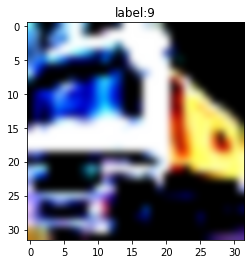

In [5]:
print("length of cifar_train: ", len(cifar_train))
print("length of cifar_test: ", len(cifar_test))

image, label = cifar_train.__getitem__(1)
print("shape of image data: ", image.size())
print("label: ", label)

img = image.numpy()

r,g,b = img[0,:,:], img[1,:,:], img[2,:,:]
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r,g,b

plt.title("label:%d" %label)
plt.imshow(img2, interpolation='bicubic')
plt.show()

정확도 검사용 함수 정의


In [0]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0
  for j, [imgs, labels] in enumerate(dloader):
    img =  torch.Tensor(imgs).requires_grad_(True).cuda()
    label = torch.Tensor.detach_(labels).cuda()

    output = imodel.forward(img)
    _, output_index = torch.max(output, 1)
    
    total += label.size(0)
    correct += (output_index == label).sum().float()
  print("Accuracy of Test Data: {}" .format(100*correct/total))
  return (100*correct/total)

데이터를 로드하고, 모델을 선언



In [0]:
# === data load function ===
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

In [0]:
# === declare CNN model ===
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3,16,3,padding=1),
        nn.BatchNorm2d(16),
        nn.ELU(),  # ELU
        nn.Dropout2d(0.0),
        nn.Conv2d(16,32,3,padding=1),
        nn.BatchNorm2d(32),
        nn.ELU(),
        nn.Dropout2d(0.1),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,3,padding=1),
        nn.BatchNorm2d(64),
        nn.ELU(),
        nn.Dropout2d(0.2),
        nn.MaxPool2d(2,2)
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(64*8*8, 128*8*8),
        nn.BatchNorm1d(128*8*8),
        nn.ELU(),
        nn.Dropout2d(0.4),
        nn.Linear(128*8*8, 100),
        nn.BatchNorm1d(100),
        nn.ELU(),
        nn.Dropout2d(0.5),
        nn.Linear(100,10)
    )
    # weight Initializaztion (He)
    for m in self.modules():
      if (isinstance(m,nn.Conv2d)):
        init.kaiming_normal_(m.weight.data)
        m.bias.data.fill_(0.1)
      if (isinstance(m,nn.Linear)):
        init.kaiming_normal_(m.weight.data)
        m.bias.data.fill_(0.1)
  def forward(self,x):
    out=self.layer(x)
    out=out.view(batch_size, -1)
    out=self.fc_layer(out)

    return out

In [0]:
model=CNN().cuda()

In [0]:
# === loss, optimizer ===
loss_func = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(),lr=learning_rate) # (5) Adam optimizer

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, verbose=True, patience=10, min_lr=0) # ReduceLRonPlateau

In [0]:
# === class for earlyStopping with Test Accuracy ===
class EarlyStopper:
  def __init__(self, patience=10, varbose=False, delta=0):
    """
    patience (int) : 성능이 개선되지 않는 epoch를 넘기는 횟수
    Varbose (bool) : 모델을 저장할 때와 훈련을 멈출 때 알림 여부
    delta (float) : 최고 성능치와 더해서 성능 향상의 기준을 만드는 값
    """
    self.patience = patience
    self.varbose = varbose
    self.delta = delta
    self.counter = 0
    self.BestScore = None
    self.earlyStop = False
    self.maxAccuracy = np.Inf

  def __call__(self, Accuracy, model):
    score = Accuracy

    if self.BestScore is None: # 처음 측정0
      self.BestScore = score
      self.save_checkpoint(Accuracy, model)
    elif score < self.BestScore + self.delta:  # BestScore보다 낮은 성능
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.earlyStop = True
                """if self.varbose:
                  print(f'Early Stop. maximum Accuracy: {self.maxAccuracy:.6f}')"""
    else:   # 기존 최고 성능보다 좋은 성능
      self.BestScore = score
      self.save_checkpoint(Accuracy, model)
      self.counter = 0

  def save_checkpoint(self, Accuracy, model):
    """ 성능이 개선되면 현재의 모델을 저장"""
    if self.varbose:
      print(f'Accuracy increased ({self.maxAccuracy:.6f} --> {Accuracy:.6f}).  Saving model ...')
    torch.save(model.state_dict(), link+'checkpoint/'+'checkpoint.pkl')
    self.maxAccuracy = Accuracy


In [0]:
earlyStopping = EarlyStopper(100, True)

model.train()
# === training ===
for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    x= torch.Tensor(image).requires_grad_(True).cuda()
    y_= torch.Tensor.detach_(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output, y_)
    loss.backward()
    optimizer.step()

  print("epoch: {}".format(i+1))

  model.eval()
  earlyStopping(ComputeAccr(test_loader, model), model)
  model.train()

  if earlyStopping.earlyStop:
    break

epoch: 1
Accuracy of Test Data: 66.71463775634766
Accuracy increased (inf --> 66.714638).  Saving model ...
epoch: 2
Accuracy of Test Data: 73.36553955078125
Accuracy increased (66.714638 --> 73.365540).  Saving model ...
epoch: 3
Accuracy of Test Data: 75.69901275634766
Accuracy increased (73.365540 --> 75.699013).  Saving model ...
epoch: 4
Accuracy of Test Data: 77.9399642944336
Accuracy increased (75.699013 --> 77.939964).  Saving model ...
epoch: 5
Accuracy of Test Data: 79.99588775634766
Accuracy increased (77.939964 --> 79.995888).  Saving model ...
epoch: 6
Accuracy of Test Data: 80.93133544921875
Accuracy increased (79.995888 --> 80.931335).  Saving model ...
epoch: 7
Accuracy of Test Data: 81.42475128173828
Accuracy increased (80.931335 --> 81.424751).  Saving model ...
epoch: 8
Accuracy of Test Data: 82.34992218017578
Accuracy increased (81.424751 --> 82.349922).  Saving model ...
epoch: 9
Accuracy of Test Data: 82.12376403808594
EarlyStopping counter: 1 out of 100
epoch: 10

In [0]:
model.load_state_dict(torch.load(link+'checkpoint/'+'checkpoint.pkl'))
model.eval()
ComputeAccr(test_loader, model)
beepsound()